# **Lab 8e: Zero-Shot Object Detection and Segmentation with Google Gemini 2.5**
Original Notebook is available [here](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-and-segmentation-with-google-gamini-2-5.ipynb). This notebook was adapted by Prof. Nils Murrugarra from Univ of Pittsburgh.

Some additional resources are [blog post](https://blog.roboflow.com/gemini-2-5-object-detection-segmentation/), and [roboflow website](https://github.com/roboflow/notebooks?tab=readme-ov-file).

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Zero-Shot Object Detection and Segmentation with Google Gemini 2.5
---
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-and-segmentation-with-google-gamini-2-5.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2507.06261-b31b1b.svg)](https://arxiv.org/abs/2507.06261)

Gemini 2.5 is Google’s latest vision-language model, released in Pro and Flash versions. Both variants are natively multimodal, supporting text, image, audio, and video inputs, and can process up to 1 million tokens of context. Gemini 2.5 Pro is designed for maximum capability, delivering strong results on tasks such as code generation, long-context reasoning, document analysis, and multimedia understanding. Gemini 2.5 Flash provides a balance of quality and efficiency with lower compute and latency requirements. Across benchmarks—including coding (LiveCodeBench 74.2% Pro), math (AIME 2025: 88% Pro), and image understanding (MMMU: 82% Pro)—Gemini 2.5 sets new standards for performance and scalability.

![Gemini 2.5 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/gemini2.5-figure-1.png)

## Environment setup

### Configure your API keys

To run Gemini 2.5, you need to provide your Google API Key. Follow these steps:

- Go to your [Google API Console](https://console.cloud.google.com/apis/credentials) and generate a new API key with access to the Gemini API.
- In Colab, open the left pane and click on `Secrets` (🔑).
    - Store your Google API Key under the name `GOOGLE_API_KEY`.
- Also this [blog post](https://blog.roboflow.com/gemini-2-5-object-detection-segmentation/) maybe helpful.

In [1]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

### Install dependencies

Installs all required Python libraries, including [`google-generativeai`](https://pypi.org/project/google-generativeai/) for Gemini 2.5 and [`supervision`](https://github.com/roboflow/supervision) for output parsing visualization.


In [2]:
!pip install google-genai supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 7.2 MB/s eta 0:00:00


### Download example data

In [3]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Initialize Gemini API client

This section creates a `genai.Client` instance using your Google API key and sets up safety filters to block potentially dangerous content when generating results with Gemini 2.5.

In [4]:
from google import genai
from google.genai import types

client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

## Prompt image for object detection



In [5]:
MODEL_NAME = "gemini-2.5-flash-preview-05-20"
TEMPERATURE = 0.5

IMAGE_PATH = "/content/dog-3.jpeg"
PROMPT = "Detect dogs tail. " + \
"Output a JSON list of bounding boxes where each entry contains the 2D bounding box in the key \"box_2d\", " + \
"and the text label in the key \"label\". Use descriptive labels."

In [6]:
from PIL import Image

image = Image.open(IMAGE_PATH)
width, height = image.size
target_height = int(1024 * height / width)
resized_image = image.resize((1024, target_height), Image.Resampling.LANCZOS)

response = client.models.generate_content(
    model=MODEL_NAME,
    contents=[resized_image, PROMPT],
    config = types.GenerateContentConfig(
        temperature=TEMPERATURE,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

response.text

'```json\n[\n  {"box_2d": [508, 335, 715, 526], "label": "dogs tail"}\n]\n```'

## Parse result and visualize

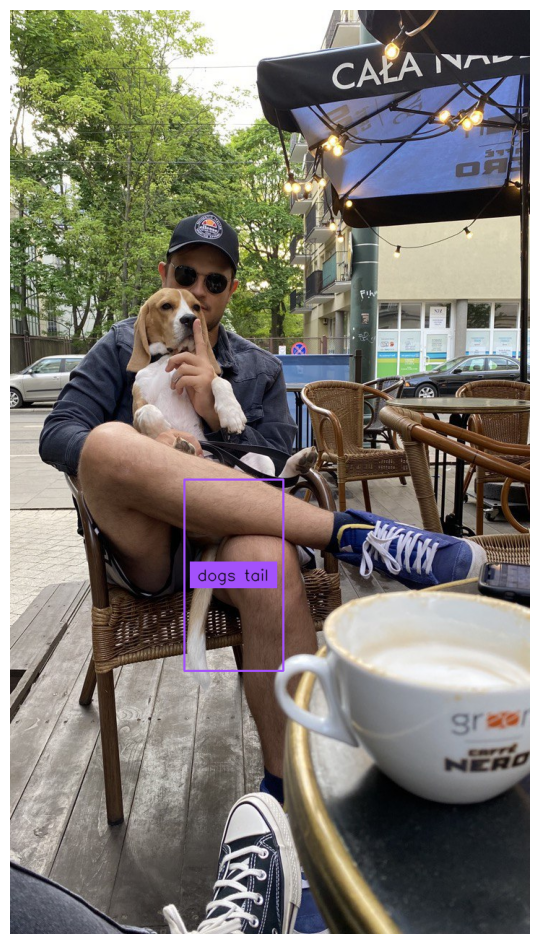

In [7]:
import supervision as sv

resolution_wh = image.size

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.GOOGLE_GEMINI_2_5,
    result=response.text,
    resolution_wh=resolution_wh
)

thickness = sv.calculate_optimal_line_thickness(resolution_wh=resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=resolution_wh)

box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    smart_position=True,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_position=sv.Position.CENTER
)

annotated = image
for annotator in (box_annotator, label_annotator):
    annotated = annotator.annotate(scene=annotated, detections=detections)

sv.plot_image(annotated)

## Prompt image for instance segmentation

In [8]:
MODEL_NAME = "gemini-2.5-flash-preview-05-20"
TEMPERATURE = 0.5

IMAGE_PATH = "/content/dog-2.jpeg"
PROMPT = "Give the segmentation masks peper, salt. " + \
"Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key \"box_2d\", " + \
"the segmentation mask in key \"mask\", and the text label in the key \"label\". Use descriptive labels."

'```json\n[\n  {"box_2d": [660, 248, 777, 365], "mask": "", "label": "peper"},\n  {"box_2d": [689, 387, 836, 532], "mask": "", "label": "salt"}\n]\n```'
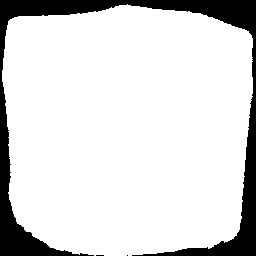
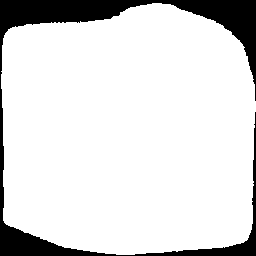

In [9]:
from PIL import Image

image = Image.open(IMAGE_PATH)
width, height = image.size
target_height = int(1024 * height / width)
resized_image = image.resize((1024, target_height), Image.Resampling.LANCZOS)

response = client.models.generate_content(
    model=MODEL_NAME,
    contents=[resized_image, PROMPT],
    config = types.GenerateContentConfig(
        temperature=TEMPERATURE,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

response.text

## Parse result and visualize

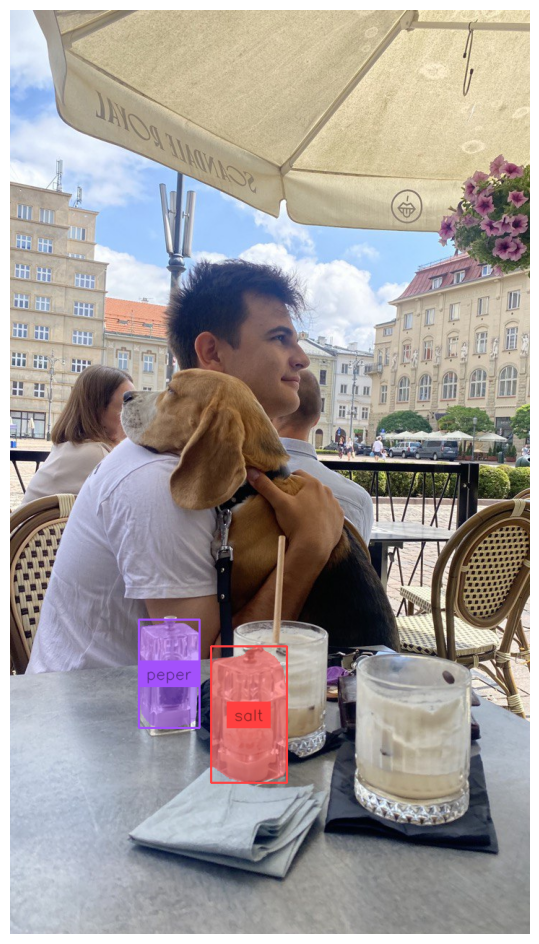

In [10]:
import supervision as sv

resolution_wh = image.size

detections = sv.Detections.from_vlm(
    vlm=sv.VLM.GOOGLE_GEMINI_2_5,
    result=response.text,
    resolution_wh=resolution_wh
)

thickness = sv.calculate_optimal_line_thickness(resolution_wh=resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=resolution_wh)

box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    smart_position=True,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_position=sv.Position.CENTER
)
masks_annotator = sv.MaskAnnotator()

annotated = image
for annotator in (box_annotator, label_annotator, masks_annotator):
    annotated = annotator.annotate(scene=annotated, detections=detections)

sv.plot_image(annotated)

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>

# Acknowledgements
Original code is available [here](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-and-segmentation-with-google-gamini-2-5.ipynb). We adapted the notebook for teaching purposes.